## <font color='red'>Distinguishing ants from bees</font>

This notebook builds a classifier that distinguishes between images of ants and bees. The classifier has three parts to it:
- The images are of varying sizes. So first, they are all normalized to a fixed size.
- Then they are run through a pre-trained computer vision neural net, ResNet50, that produces a 2048-dimensional representation
- Finally, a logistic regression classifier is built on top of this representation.

### <font color='red'>Various includes</font>

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
# Torch stuff
import torch
import torch.nn as nn
# Torchvision stuff
from torchvision import datasets, models, transforms
# sklearn stuff
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### <font color='red'>Loading Dataset</font>

For both the train and test data, the images need to be normalized to the particular size, 224x224x3, that is required by the ResNet50 network that we will apply to them. This is achieved by a series of transforms.

- The (normalized) training set is in image_datasets['train']
- The (normalized) test set is in image_datasets['val']


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

#### <font color='red'>Look at the classes and data set sizes</font>

In [3]:
class_names = image_datasets['train'].classes
class_names

['ants', 'bees']

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 244, 'val': 153}

#### <font color='red'>Print a sample (transformed) image</font>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bees



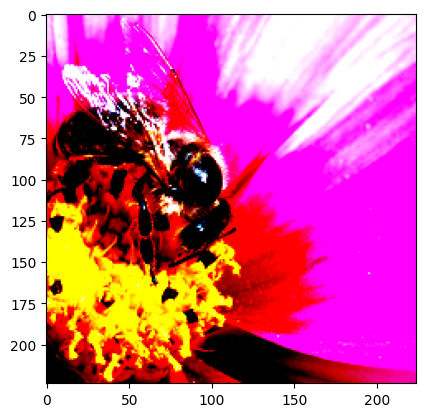

In [5]:
item = 200
[itemx,itemy] = image_datasets['train'].__getitem__(item)
print("Label: {}\n".format(class_names[itemy]))
plt.imshow(itemx.permute(1, 2, 0))
plt.show()

### <font color='red'>Load pre-trained ResNet50</font>

Torch has a bunch of pre-trained nets for computer vision. Let's try out one of them: ResNet50. 

In [6]:
resnet50 = models.resnet50(pretrained = True)
modules = list(resnet50.children())[:-1]
resnet50 = nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

C:\Users\jonat\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jonat\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\jonat/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:08<00:00, 11.6MB/s]


### <font color='red'>Extract ResNet features from dataset</font>

We'll use ResNet to produce a 2048-dimensional representation for each image.

The resulting training set will be in the Numpy arrays (X_train, y_train) and the test set will be in the Numpy arrays (X_test, y_test).


In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x])
              for x in ['train', 'val']}
for batch,data in enumerate(dataloaders['train']):
    if batch==0:
        X_train = torch.squeeze(resnet50(data[0])).numpy()
        y_train = data[1].numpy()
    else:
        X_train = np.vstack((X_train,torch.squeeze(resnet50(data[0])).numpy()))
        y_train = np.hstack((y_train,data[1].numpy()))


for batch,data in enumerate(dataloaders['val']):
    if batch==0:
        X_test = torch.squeeze(resnet50(data[0])).numpy()
        y_test = data[1].numpy()
    else:
        X_test = np.vstack((X_test,torch.squeeze(resnet50(data[0])).numpy()))
        y_test = np.hstack((y_test,data[1].numpy()))


In [8]:
np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test)

((244, 2048), (244,), (153, 2048), (153,))

### <font color='red'>Train logistic regression classifier on the ResNet features</font>

And then we'll evaluate its performance on the test set.

In [9]:
clf = LogisticRegression(solver='liblinear',random_state=0,max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0, solver='liblinear')

In [10]:
y_pred = clf.predict(X_test)
print("Accuracy: {}\n".format(accuracy_score(y_test,y_pred)))
print("Confusion matrix: \n {}".format(confusion_matrix(y_test,y_pred)))

Accuracy: 0.803921568627451

Confusion matrix: 
 [[60 10]
 [20 63]]


In [32]:
np.shape(X_train), np.shape(y_train)

((244, 2048), (244,))

In [35]:
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(X_train, y_train)

# Make predictions on the test set
y_pred_1 = knn_1.predict(X_test)

# Calculate and print the accuracy for k=1
accuracy_1 = accuracy_score(y_test, y_pred_1)
print("Test accuracy for k=1:", accuracy_1)

# Create a k-nearest neighbor classifier with k=3
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train, y_train)

# Make predictions on the test set
y_pred_3 = knn_3.predict(X_test)

# Calculate and print the accuracy for k=3
accuracy_3 = accuracy_score(y_test, y_pred_3)
print("Test accuracy for k=3:", accuracy_3)

# Create a k-nearest neighbor classifier with k=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, y_train)

# Make predictions on the test set
y_pred_5 = knn_5.predict(X_test)

# Calculate and print the accuracy for k=5
accuracy_5 = accuracy_score(y_test, y_pred_5)
print("Test accuracy for k=5:", accuracy_5)

Test accuracy for k=1: 0.6862745098039216
Test accuracy for k=3: 0.7189542483660131
Test accuracy for k=5: 0.6928104575163399
